# Project - The Battle of Neighborhoods

## Introduction

When a new person moves from India to New York due to job change or any other reasons, some questions come in his mind regarding the Indian food/restaurants e.g.

•	Which areas have potential Indian restaurant market?

•	What is best place in New York City for Indian Cuisine?

And the same problem arises when a person want to open a new Indian restaurant in the New York. The person also wants to know which is the best Borough to open a new restaurant?

So, in this project we will try to find the solution of above mentioned questions and try to find out best places in New York for Indian Cuisine and also find out the best Borough to open a new Indian restaurant. Also, we will visualize the Indian restaurants in all major parts of New York City.

## Data

For resolving the above mentioned problems, we need the following data:

•	Indian restaurants in each neighborhood of New York City
	Data Source: Foursquare API
	Description: By using this API we will get all the venues in each neighborhood. We can filter these venues to get only Indian restaurants

•	New York City data which contains list Boroughs, Neighborhoods along with their latitude and longitude
	Description: This data set contains the required information. 

And we will use this data set to explore various neighborhoods of New York City


We will import the required libraries.

In [40]:
# library to handle data in a vectorized manner
import numpy as np

# library for data analsysis
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# library to handle JSON files
import json
print('numpy, pandas, ..., imported...')

!pip -q install geopy
# conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
print('geopy installed...')
# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
print('Nominatim imported...')

# library to handle requests
import requests
print('requests imported...')

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize
print('json_normalize imported...')

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
print('matplotlib imported...')

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip -q install folium
print('folium installed...')
import folium # map rendering library
print('folium imported...')

numpy, pandas, ..., imported...
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
geopy installed...
Nominatim imported...
requests imported...
json_normalize imported...
matplotlib imported...
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
folium installed...
folium imported...


we define a function to get latitude and longitude of a given location using geopy.

In [41]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

##### Methodology

In [42]:
# Let's start

Let's define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [43]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'UYXY4PRITZONGXUJNE5WHZDO132CIAOABGIXLWH3KKSCODYZ' # your Foursquare ID
    CLIENT_SECRET = 'J00XHEBQIWB5FZC4UFLRUCCTLCRLO21IGC0UV4ISGIYEAKDD' # your Foursquare Secret
    VERSION = '20190605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Let's define a function to get venue details like like count , rating , tip counts for a given venue id.

In [68]:
 def get_venue_details(venue_id):
        
     CLIENT_ID = 'Y2MQTFDXRP25NUSFS4XT5EPM3RWHVVDXQURS4GARWWERRBP0' # your Foursquare ID
     CLIENT_SECRET = 'HLGAWVJ43MCVLWTTPFXNLVVR1PDT3FEXPGFOSNUJ01F2FSKV' # your Foursquare Secret
     VERSION = '20190605' # Foursquare API version
    
     #url to fetch data from foursquare api
     url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
             venue_id,
             CLIENT_ID, 
             CLIENT_SECRET, 
             VERSION)
    
     # get all the data
     results = requests.get(url).json()
     venue_data=results['response']['venue']
     venue_details=[]
     try:
         venue_id=venue_data['id']
         venue_name=venue_data['name']
         venue_likes=venue_data['likes']['count']
         venue_rating=venue_data['rating']
         venue_tips=venue_data['tips']['count']
         venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
     except KeyError:
         pass
        
     column_names=['ID','Name','Likes','Rating','Tips']
     df = pd.DataFrame(venue_details,columns=column_names)
     return df


Let's get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [45]:
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [46]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [47]:
new_york_data.shape

(306, 4)

Let's visualize number of Neighborhood for each Borough in New York City.

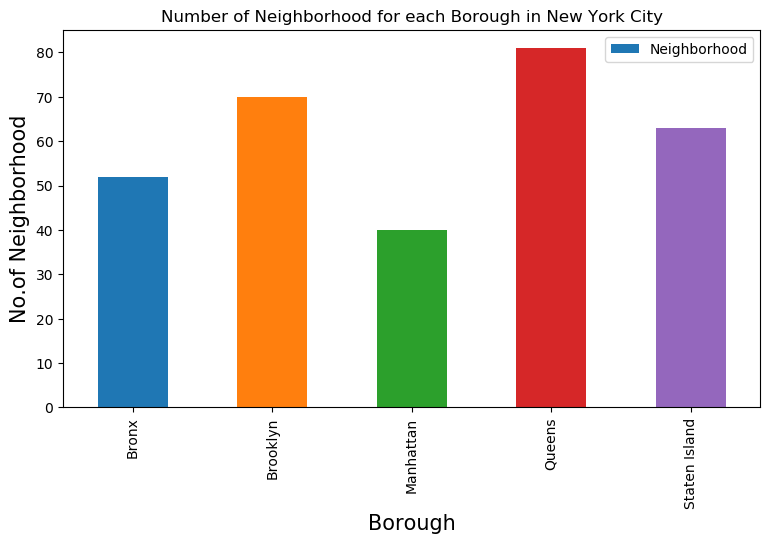

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has highest number of neighborhoods.

Now we will collect Indian resturants for each Neighborhood

In [49]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude, Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

In [50]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Williamsbridge,570c3a3fcd10eecd0d0434cd,Agra Grill
2,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird


In [51]:
indian_rest_ny.shape

(148, 4)

We got 148 Indian Resturants across New York City

Let's visualize number of Indian Resturants for each Borough in New York City.

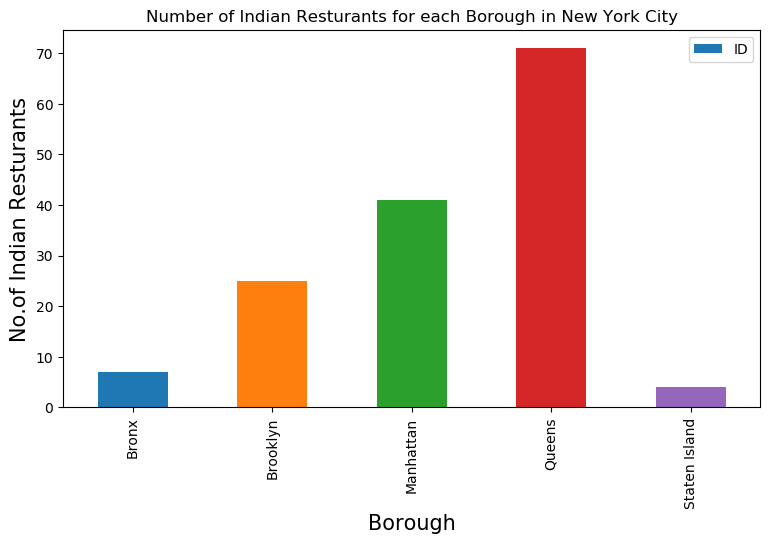

In [52]:
%matplotlib inline
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

'Staten Island' and 'Bronx' both have less than 10 Indian Restaurant, so these both places are suitable for opening a new restaurant.
'Queens' have highest number of indian restaurants.

Let's visualize number of Indian Resturants for top 20 Neighborhoods in New York City.

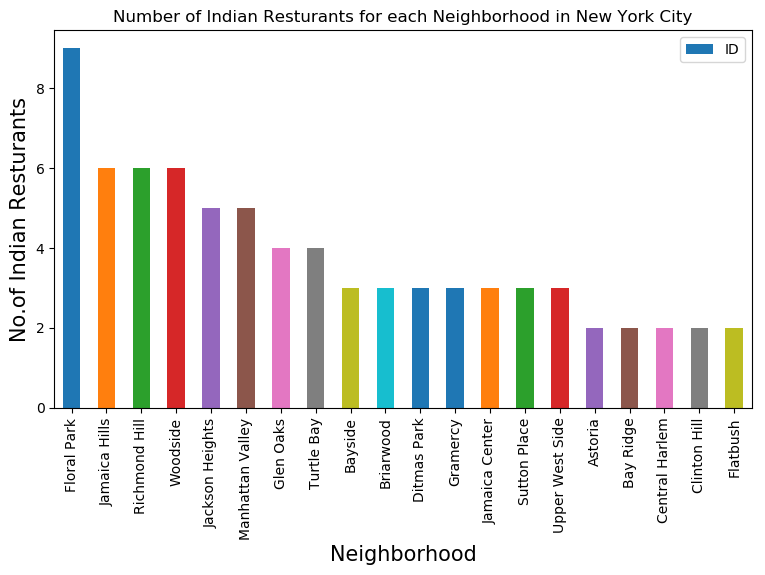

In [53]:
%matplotlib inline
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(20).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [54]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
101,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
102,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
103,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
104,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
105,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
106,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
107,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
108,Queens,Floral Park,55d68c1b498ecf05fa196fe1,Namaste Restaurant and Cafe
109,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


So Floral Park in Queens has the highest number of Indian Resturants with a total count of 9.

Let's get the ranking of each resturant for further analysis.

In [69]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        #print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    #print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

No data available for id= 570c3a3fcd10eecd0d0434cd
No data available for id= 579e8145498ec3cf1ca04dd8
No data available for id= 579e8145498ec3cf1ca04dd8
No data available for id= 5682cfde498e0a65d524f8dd
No data available for id= 4dc0aaedae606fe8b71c226b
No data available for id= 5401515e498e60d0fe0abe3b
No data available for id= 55d68c1b498ecf05fa196fe1
No data available for id= 4e6bfe1c7d8b2c711b17bbe5
No data available for id= 4b8d5734f964a520b1f532e3
No data available for id= 4dc0aaedae606fe8b71c226b
No data available for id= 59fcbd4edb1d813e71197d23
No data available for id= 4cb4a712db32f04dcb5adf4d
No data available for id= 5b00c131b399f7002c0d0d6b


In [70]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,4,7.9,10
1,Bronx,Williamsbridge,0,0,0,0.0,0
2,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.2,2
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.1,9
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,7.6,3


In [71]:
indian_rest_stats_ny.shape

(148, 7)

start visualization

In [77]:
# Resturant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                           Queens
Neighborhood            Long Island City
ID              5b931ea69d7468002c3b1382
Name                                Adda
Likes                                 84
Rating                               9.1
Tips                                  24
Name: 79, dtype: object

lets visualize neighborhood with maximum average rating of resturants

In [78]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [79]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
5,Blissville,9.100000
65,Sunnyside,9.100000
69,Tribeca,9.000000
12,Civic Center,9.000000
47,Murray Hill,8.900000
75,West Village,8.800000
44,Midtown,8.800000
45,Midtown South,8.800000
30,Gramercy,8.733333
62,South Side,8.700000


Above are the top neighborhoods with top average rating of Indian resturants

In [80]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [81]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.263415
4,Staten Island,7.900000
1,Brooklyn,7.496000
3,Queens,6.436620
0,Bronx,5.942857


Above, these are the average rating of Indian Resturants for each Borough

Lets visualize it

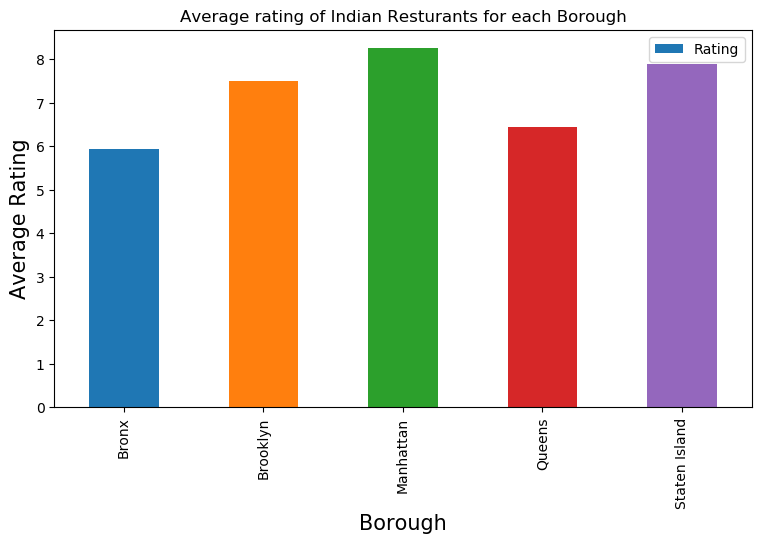

In [82]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 8.0 to visualize on map

In [83]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]

In [84]:
ny_neighborhood_stats.shape

(38, 2)

We will join this dataset to original new york data to get lonitude and latitude

In [85]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [86]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [87]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Astoria,40.768509,-73.915654,8.350000
1,Brooklyn,Bay Ridge,40.625801,-74.030621,8.000000
2,Queens,Blissville,40.737251,-73.932442,9.100000
3,Manhattan,Carnegie Hill,40.782683,-73.953256,8.500000
4,Manhattan,Central Harlem,40.815976,-73.943211,8.150000
5,Manhattan,Chelsea,40.744035,-74.003116,8.600000
6,Staten Island,Chelsea,40.594726,-74.189560,8.600000
7,Manhattan,Civic Center,40.715229,-74.005415,9.000000
8,Brooklyn,Clinton Hill,40.693229,-73.967843,8.250000
9,Brooklyn,East Flatbush,40.641718,-73.936103,8.200000


Now we will show this data on a map

In [88]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [89]:
incidents = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose

In [90]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [91]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

### Discussion and Conclusion:

Blissville(Queens), Civic Center(Manhattan) are some of the best neighborhoods for indian cuisine.

Manhattan have potential Indian Resturant Market.

'Queens' (Borough) have highest number of indian restaurants.

'Flora Park' (Neighborhood) has highhest number of Indian Resturants.

Manhattan is the best place to stay if you prefer Indian Cuisine because it has highest average rating of Indian Resturants.

'Staten Island' and 'Bronx' both have minimun number of Indian Restaurants, so these both places are suitable for opening a new restaurant.